In [8]:
#Title tokenize etme yani sayısallaştırma 
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# CSV dosyasını yükle
df = pd.read_csv("data_all_news.csv")

# Tokenizer nesnesini oluşturma
max_words = 1500  # En fazla 2500 kelimeyi dikkate alır
oov_tok = "<OOV>"  # Sözlükte olmayan kelimeler için kullanılacak token
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_tok)

# 'Title' sütunundaki haber başlıkları ile tokenizer'ı eğitiyoruz
tokenizer.fit_on_texts(df['Title'])

# Başlıkları sayısal dizilere dönüştürme
sequences = tokenizer.texts_to_sequences(df['Title'])

# Kelime sözlüğünü almak
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

# Dizileri aynı uzunlukta olacak şekilde doldurmak
max_len = 15  # Başlıkların uzunluğunu 20 kelimeye sabitliyoruz
X_pad = pad_sequences(sequences, maxlen=max_len)

# Etiketleri (Label) numpy dizisine dönüştürün
y = df['Label'].values

# X_pad ve y'yi birleştirerek yeni bir DataFrame oluştur
df_padded = pd.DataFrame(X_pad, columns=[f"word_{i+1}" for i in range(max_len)])

# Etiketleri ekleyelim
df_padded['Label'] = y

# Yeni veriyi yeni bir CSV dosyasına kaydedelim
df_padded.to_csv('data_all_with_tokenized_titles.csv', index=False)

# İlk birkaç satırı kontrol et
print(df_padded.head())

Found 22440 unique tokens.
   word_1  word_2  word_3  word_4  word_5  word_6  word_7  word_8  word_9  \
0       0       0       0       0       0       0       0      47      25   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0      26   
3       0       0       0       0       0       0       0       0       1   
4       0       0       0       0       0       0      99     810       1   

   word_10  word_11  word_12  word_13  word_14  word_15  Label  
0      393        1        1        1       81        2      0  
1        0        0      699      380        1        2      0  
2        1      381        1       18        6       14      0  
3      536       53        1        1        4        2      0  
4        1        1        1        1        1        1      1  


In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical  

# Eğitim ve test verilerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=0)

# Etiketleri one-hot encode etme (eğer daha önce yapılmadıysa)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Eğitim ve test setlerinin boyutlarını kontrol etme
print("Shape of X_train:", X_train.shape) #Eğitim verisinin boyutları
print("Shape of y_train:", y_train.shape) #her etiket iki kategoriye ( 0 ve 1) dönüştürüldü
print("Shape of X_test:", X_test.shape)   #Test verisinin boyutu
print("Shape of y_test:", y_test.shape)   #2 kategori 

Shape of X_train: (10178, 15)
Shape of y_train: (10178, 2)
Shape of X_test: (2545, 15)
Shape of y_test: (2545, 2)


In [10]:
#https://fasttext.cc/docs/en/crawl-vectors.html bu siteden direkt .bin.gz uzantılı Türkçe klasörünü indirmen lazım . sonra pip install fasttext
#Türkçe FastText Modeliyle Vektörleri Yükleme
import fasttext
import numpy as np
fasttext.FastText.eprint = lambda x: None

In [11]:
# FastText modelini yükleme
model = fasttext.load_model('models/cc.tr.300.bin')

In [12]:
# Vektör boyutu
embedding_dim = 300  # FastText'in Türkçe modeli 300 boyutlu vektörler kullanır

In [13]:
# Embedding index oluşturma
embeddings_index = {}

In [14]:
# Verilerdeki her kelimenin vektörünü alın
for word in model.get_words():
    embeddings_index[word] = model.get_word_vector(word)

In [16]:
# Veriyi Hazırlama ve Embedding Matrisi Oluşturma
# Embedding matrisi oluşturma (tüm kelimeler için)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [17]:
#Modeli Kurma ve Eğitim
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, Dense

In [23]:
# Modeli oluşturma
#Girdi olarak kelime dizilerini alır ve her kelimeyi embedding vektörüne dönüştürür.

# Modeli oluşturma
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, 
              output_dim=embedding_dim, 
              input_length=max_len, 
              weights=[embedding_matrix], 
              trainable=False),
    Dropout(0.2),                                                          # Aşırı öğrenmeyi (overfitting) engeller
    Conv1D(128, 5, activation='relu'),                                     #bir kelime grubunun belirli bir sınıfla ilişkili olup olmadığını öğrenir.
    MaxPooling1D(pool_size=4),                                             #Özellik haritasının boyutunu küçültmek ve en belirgin özellikleri seçmek.
    Dropout(0.2),                                                          # Aşırı öğrenmeyi engellemek için nöronların %20'sini rastgele devre dışı bırakır.
    LSTM(128),                                                             #  Sekans verilerinde uzun vadeli ilişkileri öğrenir. 
    Dense(2, activation='softmax')                                         # Her girdinin 5 sınıftan birine ait olma olasılığını verir.
])

In [24]:
# Modeli derleme
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     6,732,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,732,300 (25.68 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,732,300 (25.68 MB)

In [25]:
#Modeli Eğitme
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 174ms/step - accuracy: 0.6544 - loss: 0.5844 - val_accuracy: 0.7851 - val_loss: 0.4481
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.8040 - loss: 0.4084 - val_accuracy: 0.8031 - val_loss: 0.4149
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.8196 - loss: 0.3735 - val_accuracy: 0.8063 - val_loss: 0.4000
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.8392 - loss: 0.3414 - val_accuracy: 0.8071 - val_loss: 0.4169
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.8548 - loss: 0.3148 - val_accuracy: 0.8185 - val_loss: 0.3850


In [26]:
#epochsu 10 yaptım
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.8715 - loss: 0.2810 - val_accuracy: 0.8228 - val_loss: 0.3806
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 138ms/step - accuracy: 0.8672 - loss: 0.2842 - val_accuracy: 0.8200 - val_loss: 0.3938
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.8817 - loss: 0.2650 - val_accuracy: 0.8165 - val_loss: 0.4204
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.8893 - loss: 0.2460 - val_accuracy: 0.8145 - val_loss: 0.4465
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.8807 - loss: 0.2512 - val_accuracy: 0.8114 - val_loss: 0.4304
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.8944 - loss: 0.2386 - val_accuracy: 0.8169 - val_loss: 0.4393
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - accuracy: 0.8956 - loss: 0.2205 - val_accuracy: 0.8004 - val_loss: 0.5374
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 45s 157ms/step - accuracy: 0.8996 - loss: 0

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback fonksiyonu
early_stopping = EarlyStopping(monitor='val_loss',  # 'val_loss' veya 'val_accuracy' seçebilirsiniz
                               patience=3,  # 3 epok boyunca gelişme olmazsa durdurur
                               restore_best_weights=True)  # En iyi ağırlıkları geri yükler
history = model.fit(X_train, y_train, epochs=15, batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])
#Eğitim doğruluğu (accuracy) sürekli artmakta ve eğitim kaybı (loss) düşmektedir. Ancak doğrulama verileri üzerinde modelin performansı sabit veya kötüleşiyor.

Epoch 1/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9064 - loss: 0.1982 - val_accuracy: 0.8220 - val_loss: 0.4994
Epoch 2/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 49s 189ms/step - accuracy: 0.9083 - loss: 0.1974 - val_accuracy: 0.8204 - val_loss: 0.4917
Epoch 3/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 221ms/step - accuracy: 0.9118 - loss: 0.1925 - val_accuracy: 0.8189 - val_loss: 0.4938
Epoch 4/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - accuracy: 0.9101 - loss: 0.1912 - val_accuracy: 0.8212 - val_loss: 0.4861
Epoch 5/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 54s 265ms/step - accuracy: 0.9074 - loss: 0.1942 - val_accuracy: 0.8220 - val_loss: 0.5140
Epoch 6/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 75s 215ms/step - accuracy: 0.9087 - loss: 0.1909 - val_accuracy: 0.8149 - val_loss: 0.5831
Epoch 7/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - accuracy: 0.9162 - loss: 0.1762 - val_accuracy: 0.8141 - val_loss: 0.5710


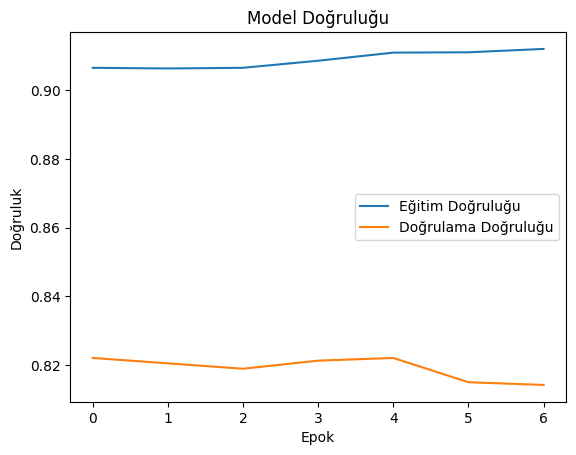

In [34]:
import matplotlib.pyplot as plt
# Eğitim ve doğrulama doğruluğunu görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epok')
plt.ylabel('Doğruluk')
plt.legend(loc='best')
plt.show()

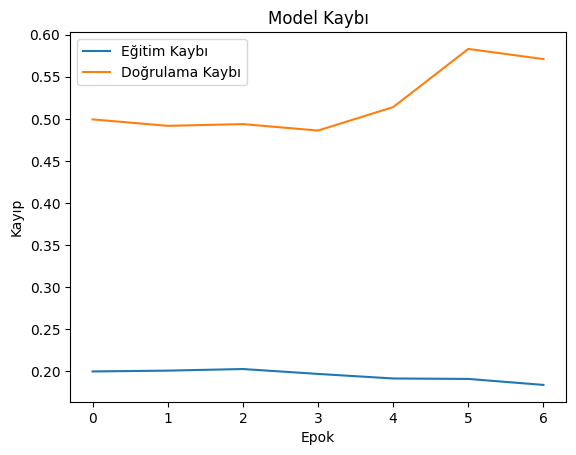

In [35]:
# Eğitim ve doğrulama kaybını görselleştirme
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.legend(loc='best')
plt.show()

In [33]:
#Doğrulama verisinde iyileşme devam etmediği için overfitting riski yüksek olduğundan eğitimi sonlandırıyorum burada.

In [37]:
loss, acc = model.evaluate(X_test, y_test)
print('Test accuracy:', acc)
print('Test score:', loss)


80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8227 - loss: 0.4742
Test accuracy: 0.8212180733680725
Test score: 0.48612287640571594
